In [1]:
%load_ext autoreload
%autoreload 2

In [140]:
import pandas as pd
import numpy as np
import os
import sys
import glob
import calendar
import project_func as pf
import geopandas as gpd
import math
import pvlib
import matplotlib.pyplot as plt
import proplot as pplt
import seaborn as sns
project_root = pf.get_project_dir()

module_path = "/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench"
sys.path.insert(0, module_path)
from ipv_workbench.utilities import utils

In [3]:
future_weather_dir = os.path.join(project_root, 'weather_files', 'morphed')

hist_epw_files = glob.glob(os.path.join(project_root, 'weather_files', 'tmy3', '*.epw'))

cz = '1a'
hist_epw_file = [f for f in hist_epw_files if cz in f][0]
ssp126_epw_files = glob.glob(os.path.join(future_weather_dir, cz, 'ssp126', 'EPWs', 'ssp126_50*.epw'))
ssp245_epw_files = glob.glob(os.path.join(future_weather_dir, cz, 'ssp245', 'EPWs', 'ssp245_50*.epw'))
ssp585_epw_files = glob.glob(os.path.join(future_weather_dir, cz, 'ssp585', 'EPWs', 'ssp585_50*.epw'))

In [4]:

climate_zones_shp = os.path.join(project_root, 'notebooks', 'input_data', 'climate_zones', 'ClimateZones.shp')

zones = gpd.read_file(climate_zones_shp)
zones = zones[~pd.isna(zones['State'])]
zones = zones[~pd.isna(zones['IECC21'])]
zones['Moisture21'] = zones['Moisture21'].fillna('A').str.lower()
zones['IECC21'] = zones['IECC21'].astype(int)
# change LA to 3bc
row_idx = zones[zones['Country']=='Los Angeles'].index[0]
zones.loc[row_idx,'Moisture21'] = 'bc'
zones['climate_zone'] = zones['IECC21'].astype(str) + zones['Moisture21']
zones = zones[zones['climate_zone']!='5c']
# zones = zones[zones['State']!='Hawaii']
zones = zones.to_crs(epsg=2163)
zones['cz_color'] = zones['climate_zone'].map(pf.get_color_dict())
# zones['grid_emissions'] = zones['climate_zone'].map(grid_ann_cz)


# Variable Box Plots

In [209]:
utils.tmy_to_dataframe(f_126)[variables]['relhum_percent'].min()

21.78133776057445

In [220]:
variables = ['drybulb_C', 'relhum_percent', 'dirnorrad_Whm2', 'difhorrad_Whm2']


weather_dict = {}
for cz in pf.get_cz_list():
    weather_dict[cz] = {}
    year = 2080
    tmy_file = [f for f in hist_epw_files if cz in f][0]
    hist_df = utils.tmy_to_dataframe(tmy_file)[variables]

    ssp126_epw_files = glob.glob(os.path.join(future_weather_dir, cz, 'ssp126', 'EPWs', 'ssp126_50*.epw'))
    ssp245_epw_files = glob.glob(os.path.join(future_weather_dir, cz, 'ssp245', 'EPWs', 'ssp245_50*.epw'))
    ssp585_epw_files = glob.glob(os.path.join(future_weather_dir, cz, 'ssp585', 'EPWs', 'ssp585_50*.epw'))

    f_126 = pf.find_file(ssp126_epw_files, pf.get_year_bands(year))
    f_245 = pf.find_file(ssp245_epw_files, pf.get_year_bands(year))
    f_585 = pf.find_file(ssp585_epw_files, pf.get_year_bands(year))

    ssp126_df = utils.tmy_to_dataframe(f_126)[variables]
    ssp245_df = utils.tmy_to_dataframe(f_245)[variables]
    ssp585_df = utils.tmy_to_dataframe(f_585)[variables]


    for var in variables:
        var_dict = {'hist':hist_df[var].values,
                    'ssp126':ssp126_df[var].values,
                    'ssp245':ssp245_df[var].values,
                    'ssp585':ssp585_df[var].values}
        weather_dict[cz].update({var:var_dict})
        

var_df_list = []
for var in variables:
    df_list = []
    for cz in pf.get_cz_list():
        df = pd.DataFrame(weather_dict[cz][var])
        df['cz'] = cz
        df_list.append(df)
    var_df = pd.concat(df_list)
    var_df['var'] = var
    var_df_list.append(var_df)
        

In [219]:
df

,hist,ssp126,ssp245,ssp585,cz,var
0,19.4,21.7,22.4,24.3,1a,relhum_percent
1,18.9,21.2,21.8,23.8,1a,relhum_percent
2,18.9,21.2,21.8,23.8,1a,relhum_percent
3,18.9,21.2,21.8,23.8,1a,relhum_percent
4,19.4,21.7,22.4,24.3,1a,relhum_percent
...,...,...,...,...,...,...
8755,-14.0,-11.5,-11.2,-10.7,8a,relhum_percent
8756,-14.0,-11.5,-11.2,-10.7,8a,relhum_percent
8757,-14.0,-11.5,-11.2,-10.7,8a,relhum_percent
8758,-13.0,-10.5,-10.2,-9.7,8a,relhum_percent


In [218]:
var = 'relhum_percent'#, 'difhorrad_Whm2'

df = pd.concat(var_df_list)
df = df[df['var']==var]
if 'rad' in var:
    df = df[df['hist']>0]

plot_df = df.melt(id_vars=['cz','var'])
plot_df

,cz,var,variable,value
0,1a,relhum_percent,hist,19.4
1,1a,relhum_percent,hist,18.9
2,1a,relhum_percent,hist,18.9
3,1a,relhum_percent,hist,18.9
4,1a,relhum_percent,hist,19.4
...,...,...,...,...
560635,8a,relhum_percent,ssp585,-10.7
560636,8a,relhum_percent,ssp585,-10.7
560637,8a,relhum_percent,ssp585,-10.7
560638,8a,relhum_percent,ssp585,-9.7


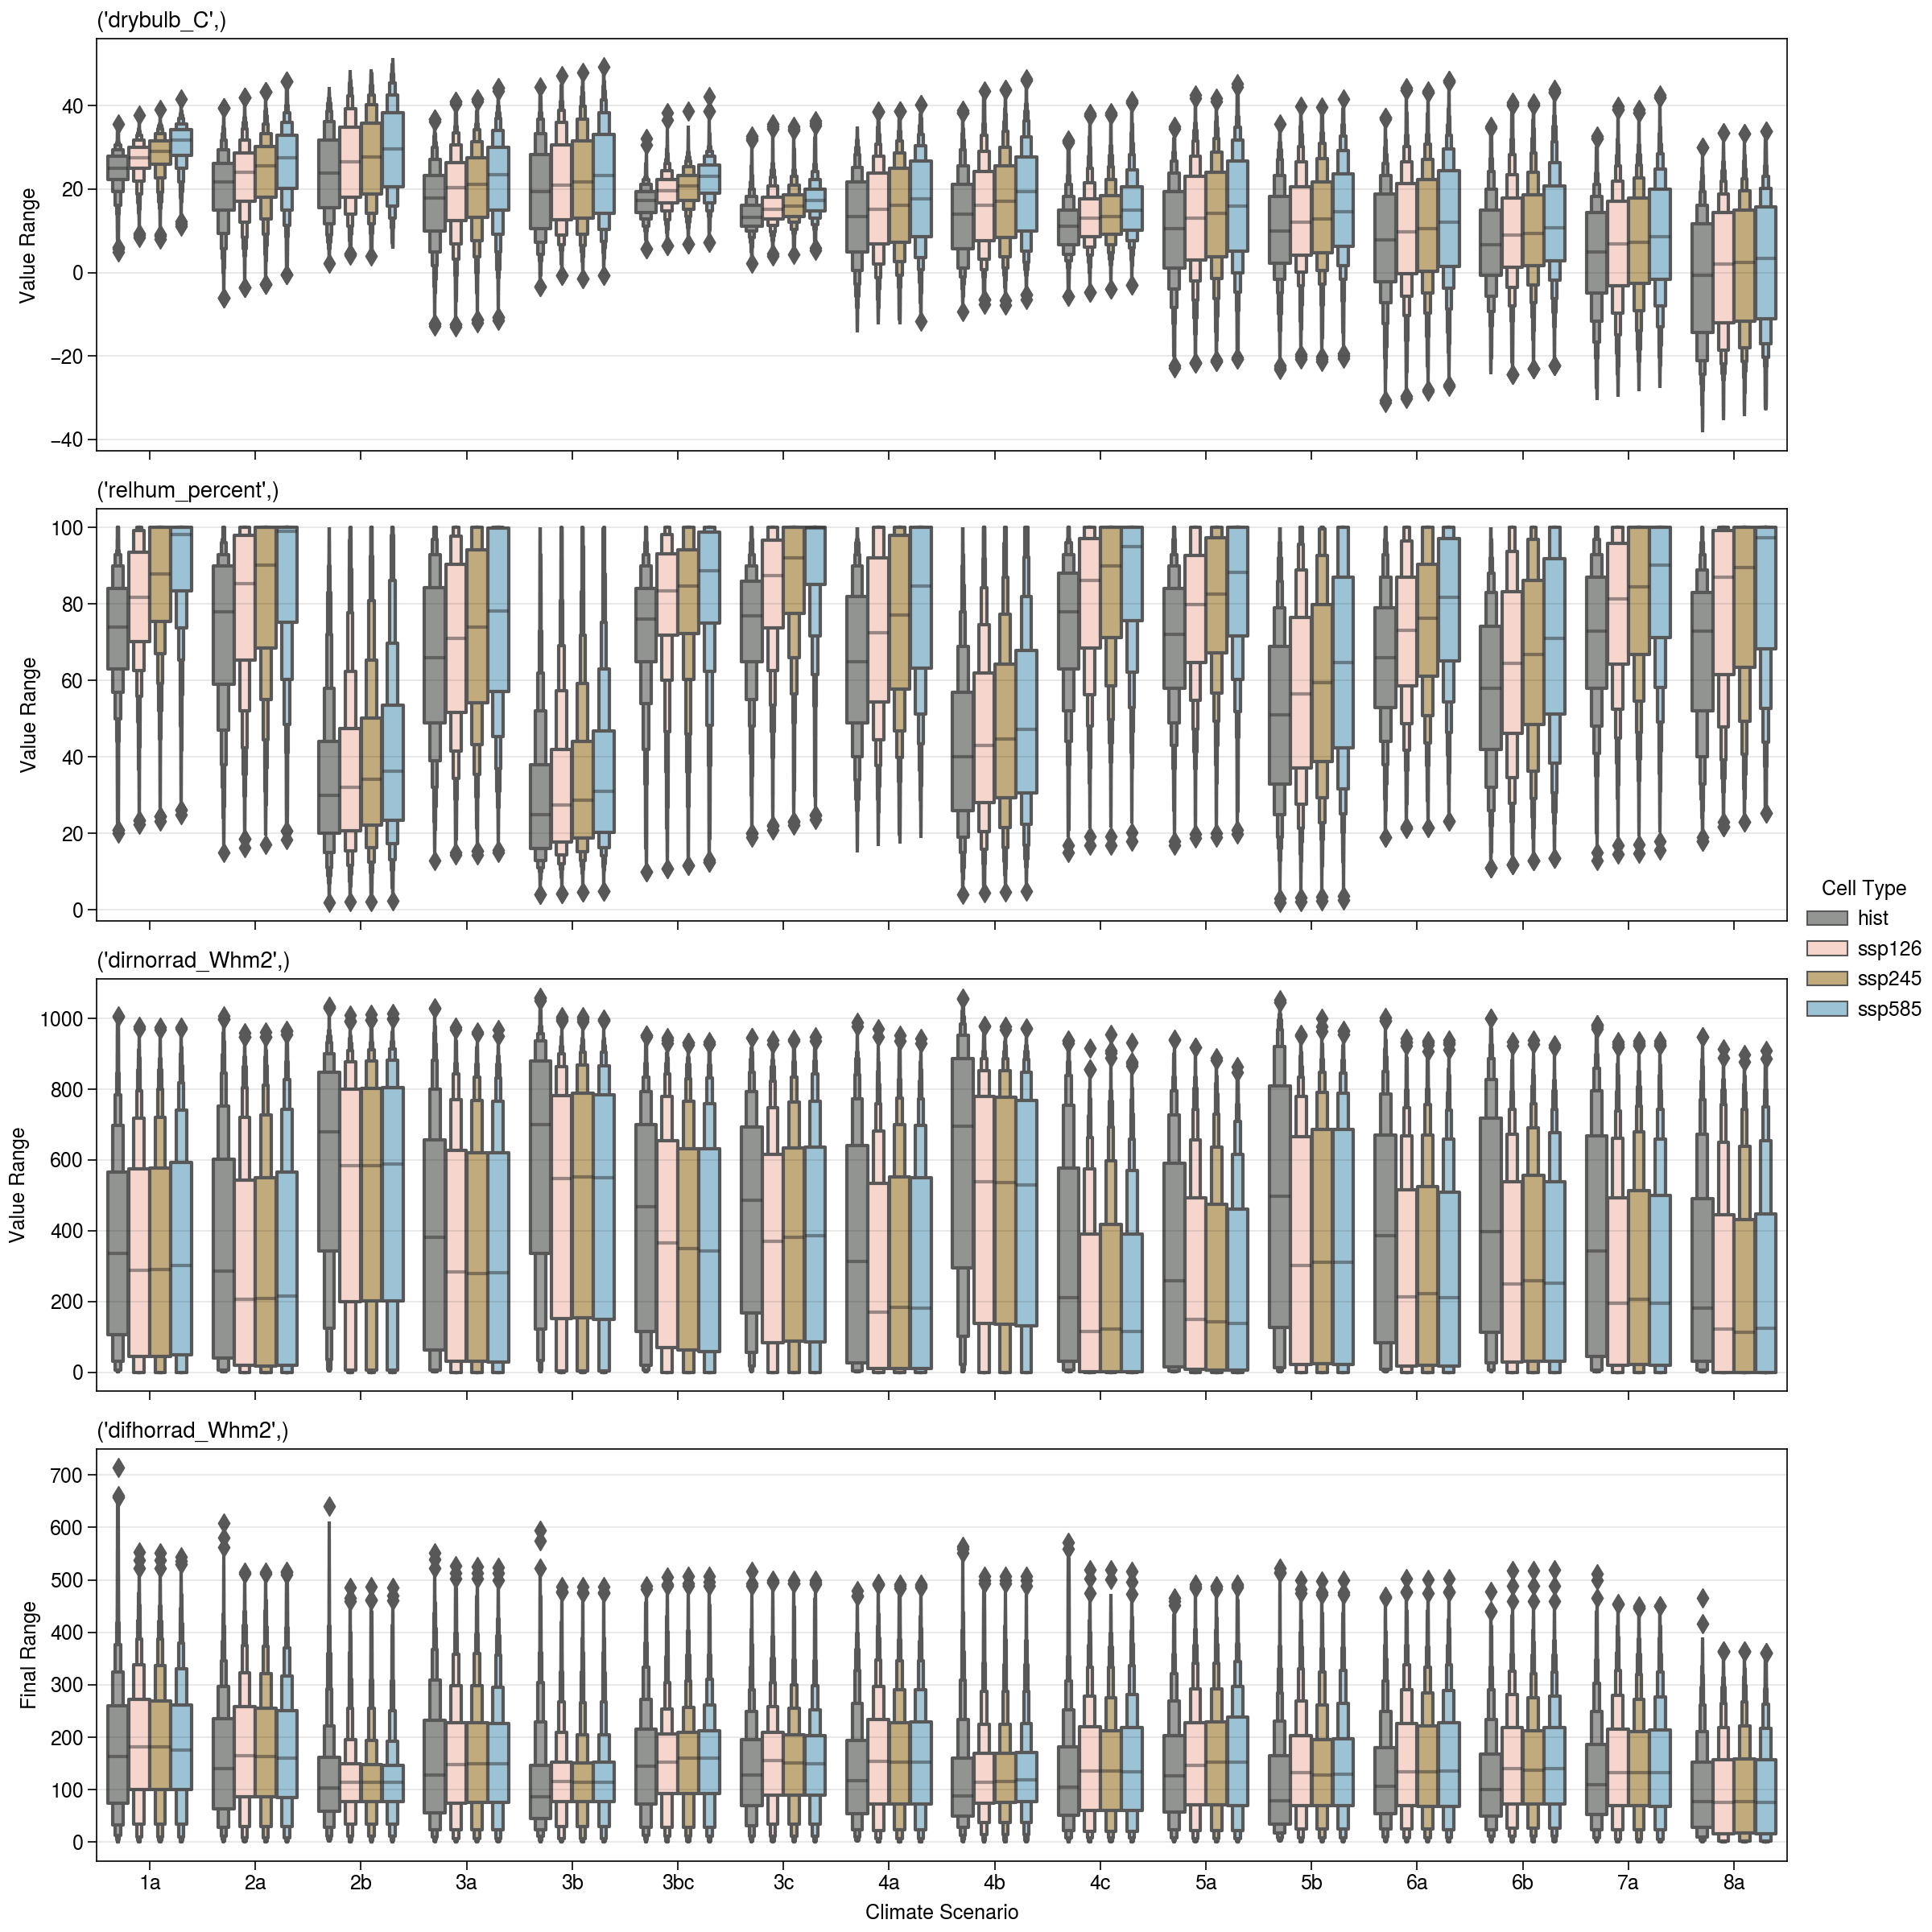

In [221]:

fig, axe = pplt.subplots(ncols=1,nrows=len(variables),figsize=(12,12),sharex=True, sharey=False,
                         facecolor='white')

for n, ax in enumerate(axe):
    var = variables[n]
    
    df = pd.concat(var_df_list)
    df = df[df['var']==var]
    if 'rad' in var:
        df = df[df['hist']>0]

    plot_df = df.melt(id_vars=['cz','var'])

    sns.boxenplot(x="cz", y="value",
                    order=pf.get_cz_list(),
                    hue_order= ['hist', 'ssp126', 'ssp245', 'ssp585'],#['west','south','east'],
                    hue="variable", 
                    palette=['grey']+list(pf.get_scenario_colors('colors-shade').values()),
                    data=plot_df,
                    ax=ax,
                    # width=1,
                    k_depth='trustworthy',
                    # flier_kws={'s':9,
                    #             'marker':'.'},
                    # box_kws={'edgecolor':'k',
                    #             'linewidth':1},
                    # line_kws={'edgecolor':'k',
                    #             'linewidth':1}
                    )
    
# delete old legends
for n, ax in enumerate(axe):
    # ax.legend([], [], frameon=False)
    var = variables[n],
    ax.format(ltitle=var,
              xlabel="Climate Scenario",
              xtickminor=False)
    ax.tick_params(direction='out', length=0, width=0, colors='k',
                   grid_color='grey', grid_alpha=0.5, which='minor')

    if n==len(variables)-1:
        ax.set_ylabel(ylabel='Final Range')
        ax.legend([], [], frameon=False)
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles=handles[0:4], labels=labels[0:4], ncols=1, label='Cell Type', loc='right', frameon=False)
    else:    
        ax.legend([], [], frameon=False)
        ax.set_ylabel(ylabel='Value Range')

# Warm hours

In [5]:
delta_dict = {}

for cz in pf.get_cz_list():
    delta_dict[cz] = {}
    hist_epw_file = [f for f in hist_epw_files if cz in f][0]
    n_hours_g_26_hist = sum(utils.tmy_to_dataframe(hist_epw_file)['drybulb_C']>26)
    
    ssp126_epw_files = glob.glob(os.path.join(future_weather_dir, cz, 'ssp126', 'EPWs', 'ssp126_50*.epw'))
    ssp245_epw_files = glob.glob(os.path.join(future_weather_dir, cz, 'ssp245', 'EPWs', 'ssp245_50*.epw'))
    ssp585_epw_files = glob.glob(os.path.join(future_weather_dir, cz, 'ssp585', 'EPWs', 'ssp585_50*.epw'))
    
    for year in pf.get_years():
        f_126 = pf.find_file(ssp126_epw_files, pf.get_year_bands(year))
        f_245 = pf.find_file(ssp245_epw_files, pf.get_year_bands(year))
        f_585 = pf.find_file(ssp585_epw_files, pf.get_year_bands(year))
        
        for ssp in [f_126, f_245, f_585]:
            n_hours_g_26_fut = sum(utils.tmy_to_dataframe(ssp)['drybulb_C']>26)
            scenario = ssp.split(os.sep)[-3]
            delta_dict[cz].update({f'{scenario}_{year}':n_hours_g_26_fut - n_hours_g_26_hist})

warm_hours_df = pd.DataFrame(delta_dict).transpose()

delta_126 = warm_hours_df[['ssp126_2080']].to_dict()['ssp126_2080']
delta_245 = warm_hours_df[['ssp245_2080']].to_dict()['ssp245_2080']
delta_585 = warm_hours_df[['ssp585_2080']].to_dict()['ssp585_2080']

In [6]:
zones['D_n26_126'] = zones['climate_zone'].map(delta_126)
zones['D_n26_245'] = zones['climate_zone'].map(delta_245)
zones['D_n26_585'] = zones['climate_zone'].map(delta_585)

zones.head()

,GEOID,Country,State,IECC15,IECC21,BA15,BA21,Moisture15,Moisture21,geometry,climate_zone,cz_color,D_n26_126,D_n26_245,D_n26_585
0,G37017,Bladen,North Carolina,3.0,3,Mixed-Humid,Mixed-Humid,A,a,"POLYGON ((1908594.508 -888691.896, 1917226.443...",3a,#c55912,960,1406,2298
1,G37167,Stanly,North Carolina,3.0,3,Mixed-Humid,Mixed-Humid,A,a,"POLYGON ((1759107.569 -883582.059, 1769852.587...",3a,#c55912,960,1406,2298
2,G39153,Summit,Ohio,5.0,5,Cold,Cold,A,a,"POLYGON ((1518816.335 -259402.244, 1515622.890...",5a,#32a02e,761,979,1679
3,G42113,Sullivan,Pennsylvania,5.0,5,Cold,Cold,A,a,"POLYGON ((1897285.293 -108013.083, 1945669.474...",5a,#32a02e,761,979,1679
4,G48459,Upshur,Texas,3.0,3,Hot-Humid,Hot-Humid,A,a,"POLYGON ((456109.472 -1356476.609, 454827.653 ...",3a,#c55912,960,1406,2298


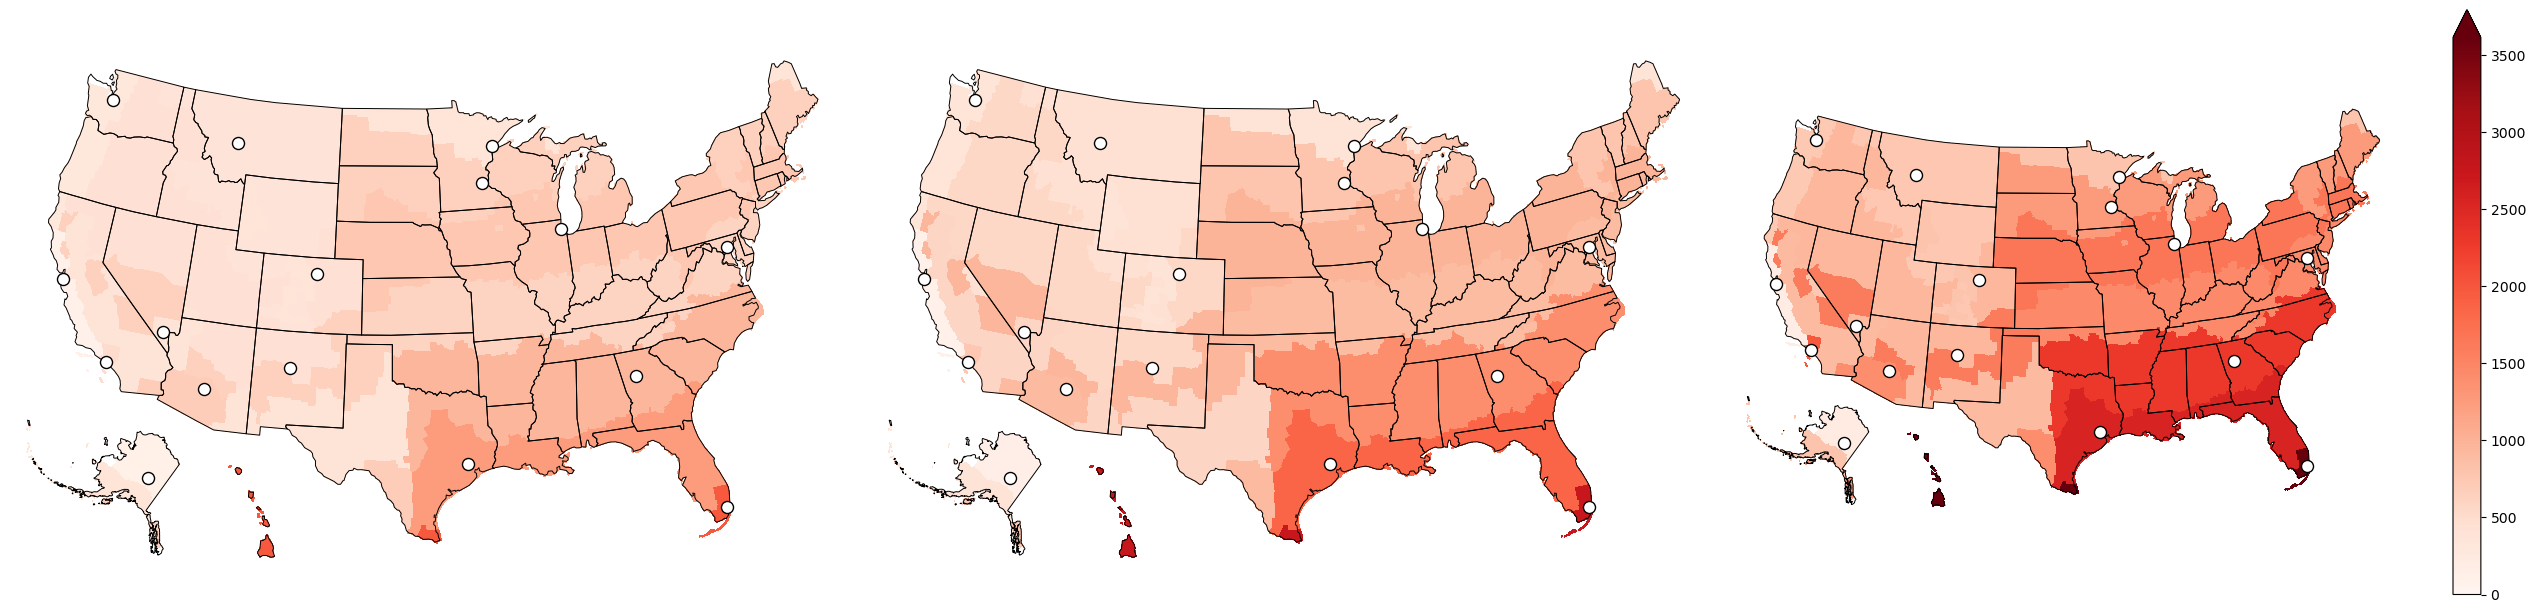

In [8]:

lgd_label = r'Shift in Number of Days over 26˚'
lgd_kw = {'location': 'right',
        'pad': -0.02,
        'shrink': 0.35,
        'extend': 'max',
        'spacing': 'uniform',
        'label': lgd_label,
        }

cmap = 'Reds'
plot_cols = ['D_n26_126','D_n26_245','D_n26_585']
vmin = 0# -zones[plot_cols].max().max()
vmax = zones[plot_cols].max().max()

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(26,12))
pf.plot_us_map_heatmap(zones, plot_cols[0], lgd_label, lgd=False, ax=ax1, lgd_kw=lgd_kw, cmap=cmap,
               vmin=vmin, vmax=vmax)
pf.plot_us_map_heatmap(zones, plot_cols[1], lgd_label, lgd=False, ax=ax2, lgd_kw=lgd_kw, cmap=cmap,
               vmin=vmin, vmax=vmax)
pf.plot_us_map_heatmap(zones, plot_cols[2], lgd_label, lgd=False, ax=ax3, lgd_kw=lgd_kw, cmap=cmap,
               vmin=vmin, vmax=vmax)
patch_col = ax1.collections[0]
cb = fig.colorbar(patch_col, ax=ax3, shrink=0.5, extend='max')
plt.show() 

# Dark hours

In [34]:

def calculate_ratio_hours(tmy_file):
    
    location = utils.tmy_location(tmy_file)
    tmy = utils.tmy_to_dataframe(tmy_file)
    solar_df = pvlib.solarposition.get_solarposition(tmy.index, #pd.DatetimeIndex
                                                    location['lat'], 
                                                    location['lon'],
                                                    altitude=location['elevation'], #[m]
                                                    pressure=tmy['atmos_Pa'], #[Pa]
                                                    method='nrel_numpy', 
                                                    temperature=tmy['drybulb_C'] #[C]
                                                    )


    surface_tilt = 45
    surface_azimuth = 180
    solar_zenith = solar_df['zenith']
    solar_azimuth = solar_df['azimuth']
    dni = tmy['dirnorrad_Whm2']
    ghi =tmy['glohorrad_Whm2']
    dhi = tmy['difhorrad_Whm2']
    dni_extra = pvlib.irradiance.get_extra_radiation(tmy.index)
    poa_beam = pvlib.irradiance.beam_component(surface_tilt, 
                                            surface_azimuth, 
                                            solar_zenith, 
                                            solar_azimuth,
                                            dni).fillna(0)
    poa_sky_diffuse = pvlib.irradiance.get_sky_diffuse(surface_tilt, 
                                                    surface_azimuth, 
                                                    solar_zenith, 
                                                    solar_azimuth,
                                                    dni, ghi, dhi, 
                                                    dni_extra=dni_extra, 
                                                    airmass=None, 
                                                    model='perez').fillna(0)


    poa_ratio = pd.Series(np.where(poa_sky_diffuse==0,0, poa_beam / poa_sky_diffuse))
    return np.sum([poa_ratio>1])

In [46]:
delta_dict = {}

for cz in pf.get_cz_list():
    delta_dict[cz] = {}
    hist_epw_file = [f for f in hist_epw_files if cz in f][0]
    tmy_df_hist = utils.tmy_to_dataframe(hist_epw_file)
    # hist_var = sum(tmy_df_hist[tmy_df_hist['dirnorrad_Whm2']>0]['dirnorrad_Whm2'])
    hist_var = calculate_ratio_hours(hist_epw_file)
    ssp126_epw_files = glob.glob(os.path.join(future_weather_dir, cz, 'ssp126', 'EPWs', 'ssp126_50*.epw'))
    ssp245_epw_files = glob.glob(os.path.join(future_weather_dir, cz, 'ssp245', 'EPWs', 'ssp245_50*.epw'))
    ssp585_epw_files = glob.glob(os.path.join(future_weather_dir, cz, 'ssp585', 'EPWs', 'ssp585_50*.epw'))
    
    for year in pf.get_years():
        f_126 = pf.find_file(ssp126_epw_files, pf.get_year_bands(year))
        f_245 = pf.find_file(ssp245_epw_files, pf.get_year_bands(year))
        f_585 = pf.find_file(ssp585_epw_files, pf.get_year_bands(year))
        
        for ssp in [f_126, f_245, f_585]:
            # n_hours_g_5_fut = sum(utils.tmy_to_dataframe(ssp)['opaqskycvr_tenths']>5)
            tmy_df_fut = utils.tmy_to_dataframe(ssp)
            # fut_var = sum(tmy_df_fut[tmy_df_fut['dirnorrad_Whm2']>0]['dirnorrad_Whm2'])
            fut_var = calculate_ratio_hours(ssp)

            scenario = ssp.split(os.sep)[-3]
            delta_dict[cz].update({f'{scenario}_{year}':fut_var - hist_var})

dark_hours_df = pd.DataFrame(delta_dict).transpose()

delta_126 = dark_hours_df[['ssp126_2080']].to_dict()['ssp126_2080']
delta_245 = dark_hours_df[['ssp245_2080']].to_dict()['ssp245_2080']
delta_585 = dark_hours_df[['ssp585_2080']].to_dict()['ssp585_2080']

zones['D_dni_126'] = zones['climate_zone'].map(delta_126)
zones['D_dni_245'] = zones['climate_zone'].map(delta_245)
zones['D_dni_585'] = zones['climate_zone'].map(delta_585)

zones.head()

,GEOID,Country,State,IECC15,IECC21,BA15,BA21,Moisture15,Moisture21,geometry,...,cz_color,D_n26_126,D_n26_245,D_n26_585,D_n5_126,D_n5_245,D_n5_585,D_dni_126,D_dni_245,D_dni_585
0,G37017,Bladen,North Carolina,3.0,3,Mixed-Humid,Mixed-Humid,A,a,"POLYGON ((1908594.508 -888691.896, 1917226.443...",...,#c55912,960,1406,2298,0,0,28,-483,-496,-492
1,G37167,Stanly,North Carolina,3.0,3,Mixed-Humid,Mixed-Humid,A,a,"POLYGON ((1759107.569 -883582.059, 1769852.587...",...,#c55912,960,1406,2298,0,0,28,-483,-496,-492
2,G39153,Summit,Ohio,5.0,5,Cold,Cold,A,a,"POLYGON ((1518816.335 -259402.244, 1515622.890...",...,#32a02e,761,979,1679,9,0,64,-602,-639,-686
3,G42113,Sullivan,Pennsylvania,5.0,5,Cold,Cold,A,a,"POLYGON ((1897285.293 -108013.083, 1945669.474...",...,#32a02e,761,979,1679,9,0,64,-602,-639,-686
4,G48459,Upshur,Texas,3.0,3,Hot-Humid,Hot-Humid,A,a,"POLYGON ((456109.472 -1356476.609, 454827.653 ...",...,#c55912,960,1406,2298,0,0,28,-483,-496,-492


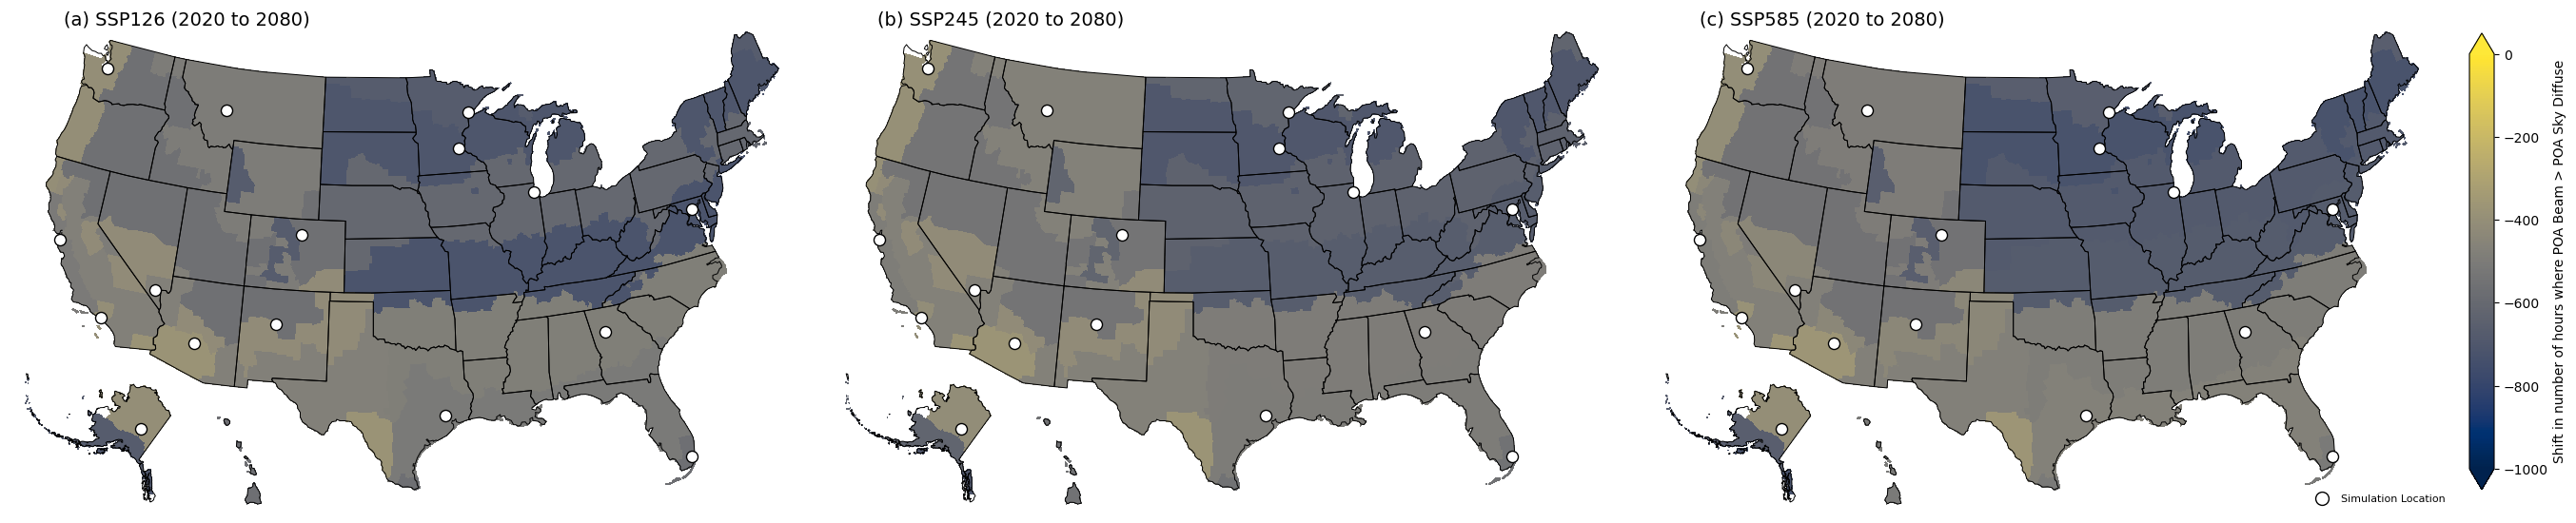

In [89]:

lgd_label = r'Shift in number of hours where POA Beam > POA Sky Diffuse'
lgd_kw = {'location': 'right',
        'pad': -0.02,
        'shrink': 0.35,
        'extend': 'max',
        'spacing': 'uniform',
        'label': lgd_label,
        }

cmap = 'cividis'
plot_cols = ['D_dni_126','D_dni_245','D_dni_585']
vmin = -1000# -zones[plot_cols].max().max()
vmax = 0#-zones[plot_cols].max().max()

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(26,12))
pf.plot_us_map_heatmap(zones, plot_cols[0], lgd_label, lgd=False, ax=ax1, lgd_kw=lgd_kw, cmap=cmap,
               vmin=vmin, vmax=vmax)
pf.plot_us_map_heatmap(zones, plot_cols[1], lgd_label, lgd=False, ax=ax2, lgd_kw=lgd_kw, cmap=cmap,
               vmin=vmin, vmax=vmax)
pf.plot_us_map_heatmap(zones, plot_cols[2], lgd_label, lgd=False, ax=ax3, lgd_kw=lgd_kw, cmap=cmap,
               vmin=vmin, vmax=vmax)
# patch_col = ax1.collections[0]
# cb = fig.colorbar(patch_col, ax=ax3, shrink=0.5, extend='max')

ax1.text(0.22, 0.98, '(a) SSP126 (2020 to 2080)', fontsize=14,
         horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
ax2.text(1.23, 0.98, '(b) SSP245 (2020 to 2080)', fontsize=14,
         horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
ax3.text(2.25, 0.98, '(c) SSP585 (2020 to 2080)', fontsize=14,
         horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)



cbar_ax = fig.add_axes([1.0, 0.30, 0.01, 0.4])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cbar_ax, extend='both', label=lgd_label)

lgd_el_tmy = pf.build_lgd(
            [('white', 'k')], ['Simulation Location'], element_type='marker')
ax3.legend(handles=lgd_el_tmy, loc='lower right', frameon=False, title='',
                        fontsize=8)

plt.show() 